# ControlNet Visual Inspector

Comprehensive testing notebook for graph-conditioned ControlNet:
1. Generate images from pure noise + graph embeddings
2. Compare with ground truth validation images
3. Test generation consistency across different seeds


## 1. Setup and Imports


In [1]:
import os
import sys
import torch
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import h5py
from tqdm.auto import tqdm
import time

from diffusers import AutoencoderKL, DDPMScheduler,DDIMScheduler, UNet2DConditionModel
from transformers import AutoModel, AutoTokenizer

# Add parent directory to path for local imports
sys.path.insert(0, '/home/luab/graph')
from controlnet.controlnet import GraphControlNet
from data_loader import CheXpertGraphDataset

print("✓ Imports complete")


/home/luab/graph/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Imports complete


## 2. Configuration


In [2]:
# Device configuration
DEVICE = "cuda"  # Options: "cuda" or "cpu"

# Set device
device = torch.device(DEVICE)
print(f"Device Configuration:")
print(f"  Device: {device}")
if DEVICE == "cuda" and torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
elif DEVICE == "cuda" and not torch.cuda.is_available():
    print("  WARNING: CUDA requested but not available! Falling back to CPU.")
    device = torch.device("cpu")

# Paths
CHECKPOINT_PATH = "/home/luab/graph/checkpoints/controlnet/checkpoint-epoch-8/controlnet.pth"
CSV_PATH = "/home/luab/graph/reports_processed.csv"
EMBEDDINGS_PATH = "/home/luab/graph/new_embeddings_expanded.h5"
IMAGE_ROOT = "/mnt/data/CheXpert/PNG"
OUTPUT_DIR = "/home/luab/graph/adhoc_scripts/outputs"

# Generation parameters
NUM_SAMPLES = 6  # Number of validation samples to visualize
NUM_INFERENCE_STEPS = 50  # DDPM denoising steps
CONDITIONING_SCALE = 1.0  # ControlNet conditioning scale
GUIDANCE_SCALE = 1.0  # Classifier-free guidance scale (1.0 = no CFG)
SEED = 42  # Random seed for reproducibility
IMAGE_SIZE = 512

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"\nPaths:")
print(f"  Checkpoint: {CHECKPOINT_PATH}")
print(f"  Output: {OUTPUT_DIR}")

print(f"\nGeneration Parameters:")
print(f"  Samples: {NUM_SAMPLES}")
print(f"  Inference steps: {NUM_INFERENCE_STEPS}")
print(f"  Conditioning scale: {CONDITIONING_SCALE}")
print(f"  Guidance scale: {GUIDANCE_SCALE}")
print(f"  Seed: {SEED}")


Device Configuration:
  Device: cuda
  GPU: NVIDIA GeForce RTX 4090
  Memory: 23.6 GB

Paths:
  Checkpoint: /home/luab/graph/checkpoints/controlnet/checkpoint-epoch-8/controlnet.pth
  Output: /home/luab/graph/adhoc_scripts/outputs

Generation Parameters:
  Samples: 6
  Inference steps: 50
  Conditioning scale: 1.0
  Guidance scale: 1.0
  Seed: 42


## 3. Load Models


In [3]:
print("Loading models...")

# Load UNet
print("  Loading RadEdit UNet...")
unet = UNet2DConditionModel.from_pretrained(
    "microsoft/radedit",
    subfolder="unet",
).to(device)
unet.eval()
print(f"    ✓ UNet loaded ({sum(p.numel() for p in unet.parameters()):,} parameters)")

# Load VAE
print("  Loading VAE...")
vae = AutoencoderKL.from_pretrained(
    "stabilityai/sdxl-vae",
).to(device)
vae.eval()
print(f"    ✓ VAE loaded ({sum(p.numel() for p in vae.parameters()):,} parameters)")

# Load text encoder
print("  Loading BioViL-T text encoder...")
text_encoder = AutoModel.from_pretrained(
    "microsoft/BiomedVLP-BioViL-T",
    trust_remote_code=True,
).to(device)
text_encoder.eval()

tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/BiomedVLP-BioViL-T",
    model_max_length=128,
    trust_remote_code=True,
)
print("    ✓ Text encoder loaded")

# Precompute empty prompt embeddings
print("  Precomputing empty prompt embeddings...")
with torch.no_grad():
    text_inputs = tokenizer(
        [""],
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    empty_prompt_embeds = text_encoder(
        input_ids=text_inputs.input_ids.to(device),
        attention_mask=text_inputs.attention_mask.to(device),
    )
    if hasattr(empty_prompt_embeds, 'last_hidden_state'):
        empty_prompt_embeds = empty_prompt_embeds.last_hidden_state
    elif isinstance(empty_prompt_embeds, tuple):
        empty_prompt_embeds = empty_prompt_embeds[0]

print(f"    ✓ Empty prompt embeddings: {empty_prompt_embeds.shape}")

# Free text encoder from GPU
del text_encoder
torch.cuda.empty_cache()

# Load ControlNet
print("  Loading GraphControlNet...")
controlnet = GraphControlNet(unet)
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
controlnet.load_state_dict(checkpoint)
controlnet = controlnet.to(device)
controlnet.eval()
print(f"    ✓ ControlNet loaded from {CHECKPOINT_PATH}")
print(f"    ✓ Trainable parameters: {controlnet.get_num_trainable_parameters():,}")

print("\n✓ All models loaded successfully!")


Loading models...
  Loading RadEdit UNet...


    ✓ UNet loaded (439,435,652 parameters)
  Loading VAE...
    ✓ VAE loaded (83,653,863 parameters)
  Loading BioViL-T text encoder...


Some weights of the model checkpoint at microsoft/BiomedVLP-BioViL-T were not used when initializing CXRBertModel: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing CXRBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CXRBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


    ✓ Text encoder loaded
  Precomputing empty prompt embeddings...
    ✓ Empty prompt embeddings: torch.Size([1, 128, 768])
  Loading GraphControlNet...
🔧 Initializing GraphControlNet from UNet...
✅ ControlNet created from UNet
   Frozen spatial conditioning embedding
   Total ControlNet parameters: 189,498,192
   Trainable parameters: 188,854,272
    ✓ ControlNet loaded from /home/luab/graph/checkpoints/controlnet/checkpoint-epoch-8/controlnet.pth
    ✓ Trainable parameters: 188,854,272

✓ All models loaded successfully!


In [4]:
print("Loading validation dataset...")

# Create validation dataset
val_dataset = CheXpertGraphDataset(
    csv_path=CSV_PATH,
    embeddings_path=EMBEDDINGS_PATH,
    image_root=IMAGE_ROOT,
    split="valid",
    image_size=IMAGE_SIZE,
    text_field="section_impression",
    max_samples=50,  # Limit for faster inspection
)

print(f"\n✓ Validation dataset loaded: {len(val_dataset)} samples")

# Display sample info
sample = val_dataset[0]
print(f"\nSample structure:")
print(f"  Image: {sample['image'].shape} in [{sample['image'].min():.2f}, {sample['image'].max():.2f}]")
print(f"  Graph embedding: {sample['graph_embedding'].shape}")
print(f"  Text prompt: {sample['text_prompt'][:100]}...")
print(f"  Patient ID: {sample['patient_id']}")
print(f"  Original index: {sample['original_idx']}")


Loading validation dataset...
Loading CheXpertGraphDataset (split=valid)...


  Loaded CSV: 223462 total samples
  After valid filter: 234 samples
  Limited to 50 samples for testing
  Opening HDF5 embeddings: /home/luab/graph/new_embeddings_expanded.h5
  HDF5 shape: (223462, 128, 768)
✓ Dataset ready: 50 samples

✓ Validation dataset loaded: 50 samples

Sample structure:
  Image: torch.Size([3, 512, 512]) in [-1.00, 1.00]
  Graph embedding: torch.Size([128, 768])
  Text prompt: 1. SINGLE VIEW OF CHEST DEMONSTRATES NO SIGNIFICANT INTERVAL CHANGE IN POSITION OF BILATERAL CHEST T...
  Patient ID: patient64620
  Original index: 1428


## 5. Setup Scheduler


In [5]:
# Create DDPM scheduler matching training configuration
scheduler = DDIMScheduler(
    beta_schedule="linear",
    clip_sample=False,
    prediction_type="epsilon",
    timestep_spacing="trailing",
    steps_offset=1,
)


scheduler.set_timesteps(NUM_INFERENCE_STEPS)

print(f"Scheduler setup:")
print(f"  Type: DDIM")
print(f"  Beta schedule: linear")
print(f"  Prediction type: epsilon")
print(f"  Inference steps: {NUM_INFERENCE_STEPS}")
print(f"  Timesteps: {scheduler.timesteps[:5].tolist()} ... {scheduler.timesteps[-5:].tolist()}")


Scheduler setup:
  Type: DDIM
  Beta schedule: linear
  Prediction type: epsilon
  Inference steps: 50
  Timesteps: [999, 979, 959, 939, 919] ... [99, 79, 59, 39, 19]


## 6. Generation Functions


In [6]:
def generate_from_noise(graph_embedding, seed=None, show_progress=True):
    """
    Generate image from pure random noise conditioned on graph embedding.
    
    Args:
        graph_embedding: [128, 768] tensor
        seed: Random seed (optional)
        show_progress: Show progress bar
    
    Returns:
        PIL Image
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    # Prepare graph embedding
    graph_emb = graph_embedding.unsqueeze(0).to(device)  # [1, 128, 768]
    
    # Initialize random latents
    latent_channels = unet.config.in_channels
    latent_height = IMAGE_SIZE // 8
    latent_width = IMAGE_SIZE // 8
    
    latents = torch.randn(
        (1, latent_channels, latent_height, latent_width),
        device=device,
        dtype=torch.float32,
    )
    
    # Scale initial latents
    latents = latents * scheduler.init_noise_sigma
    
    # Prepare empty prompt embeddings
    empty_embeddings = empty_prompt_embeds.to(dtype=latents.dtype)
    
    # Denoising loop
    with torch.no_grad():
        iterator = tqdm(scheduler.timesteps, desc="Denoising", disable=not show_progress)
        for t in iterator:
            # Get ControlNet outputs
            down_block_res_samples, mid_block_res_sample = controlnet(
                noisy_latents=latents,
                timestep=t,
                graph_embeddings=graph_emb,
                conditioning_scale=CONDITIONING_SCALE,
                return_dict=False,
            )
            
            # Predict noise with UNet
            if GUIDANCE_SCALE > 1.0:
                # Classifier-free guidance
                latent_input = torch.cat([latents] * 2)
                encoder_hidden_states = torch.cat([empty_embeddings, empty_embeddings])
                
                down_block_res_samples_dup = [torch.cat([s] * 2) for s in down_block_res_samples]
                mid_block_res_sample_dup = torch.cat([mid_block_res_sample] * 2)
                
                noise_pred = unet(
                    latent_input,
                    t,
                    encoder_hidden_states=encoder_hidden_states,
                    down_block_additional_residuals=down_block_res_samples_dup,
                    mid_block_additional_residual=mid_block_res_sample_dup,
                    return_dict=False,
                )[0]
                
                noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + GUIDANCE_SCALE * (noise_pred_cond - noise_pred_uncond)
            else:
                # No CFG
                noise_pred = unet(
                    latents,
                    t,
                    encoder_hidden_states=empty_embeddings,
                    down_block_additional_residuals=down_block_res_samples,
                    mid_block_additional_residual=mid_block_res_sample,
                    return_dict=False,
                )[0]
            
            # Compute previous latents
            latents = scheduler.step(noise_pred, t, latents, return_dict=False)[0]
    
    # Decode latents to image
    with torch.no_grad():
        latents = latents / vae.config.scaling_factor
        image = vae.decode(latents, return_dict=False)[0]
    
    # Convert to PIL Image
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
    image = (image * 255).round().astype("uint8")
    pil_image = Image.fromarray(image)
    
    return pil_image


def tensor_to_pil(tensor):
    """
    Convert image tensor [-1, 1] to PIL Image.
    
    Args:
        tensor: [3, H, W] tensor in [-1, 1]
    
    Returns:
        PIL Image
    """
    image = (tensor / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(1, 2, 0).numpy()
    image = (image * 255).round().astype("uint8")
    return Image.fromarray(image)


print("✓ Generation functions defined")


✓ Generation functions defined


## 7. Visualization Sections

### Section A: Generation from Noise


In [7]:
print(f"Generating {NUM_SAMPLES} images from noise...\n")

generated_images = []
metadata_list = []
generation_times = []

for i in range(NUM_SAMPLES):
    sample = val_dataset[i]
    graph_embedding = sample['graph_embedding']
    
    print(f"Sample {i+1}/{NUM_SAMPLES}:")
    print(f"  Patient: {sample['patient_id']}")
    print(f"  Index: {sample['original_idx']}")
    print(f"  Prompt: {sample['text_prompt'][:80]}...")
    
    # Generate image
    start_time = time.time()
    generated_img = generate_from_noise(graph_embedding, seed=SEED + i, show_progress=False)
    gen_time = time.time() - start_time
    
    generated_images.append(generated_img)
    metadata_list.append({
        'patient_id': sample['patient_id'],
        'original_idx': sample['original_idx'],
        'text_prompt': sample['text_prompt'],
        'ground_truth': sample['image'],
    })
    generation_times.append(gen_time)
    
    print(f"  ✓ Generated in {gen_time:.2f}s\n")

print(f"\nAverage generation time: {np.mean(generation_times):.2f}s")


Generating 6 images from noise...



Sample 1/6:
  Patient: patient64620
  Index: 1428
  Prompt: 1. SINGLE VIEW OF CHEST DEMONSTRATES NO SIGNIFICANT INTERVAL CHANGE IN POSITION ...
  ✓ Generated in 9.48s

Sample 2/6:
  Patient: patient64678
  Index: 3371
  Prompt: 1. INTERVAL REMOVAL OF PREVIOUSLY SEEN SKIN STAPLES. 2. STABLE APPEARANCE OF THE...
  ✓ Generated in 4.68s

Sample 3/6:
  Patient: patient64680
  Index: 3598
  Prompt: 1. SWAN-GANZ CATHETER HAS BEEN REMOVED BUT THE ASSOCIATED SHEATH REMAINS IN THE ...
  ✓ Generated in 4.69s

Sample 4/6:
  Patient: patient64592
  Index: 4978
  Prompt: 1. ENLARGEMENT OF CARDIO/PERICARDIAL SILHOUETTE AGAIN SEEN. VASCULAR REDISTRIBUT...
  ✓ Generated in 4.76s

Sample 5/6:
  Patient: patient64729
  Index: 4998
  Prompt: 1.FEEDING TUBE AND SPINAL FIXATION RODS AGAIN NOTED IN PLACE. CARDIOMEGALY AGAIN...
  ✓ Generated in 4.84s

Sample 6/6:
  Patient: patient64545
  Index: 9724
  Prompt: 1. TRACE PULMONARY EDEMA WITH LEFT PLEURAL EFFUSION. 2. LOW LUNG VOLUMES AND LEF...
  ✓ Generated in

Saved: /home/luab/graph/adhoc_scripts/outputs/generation_from_noise.png


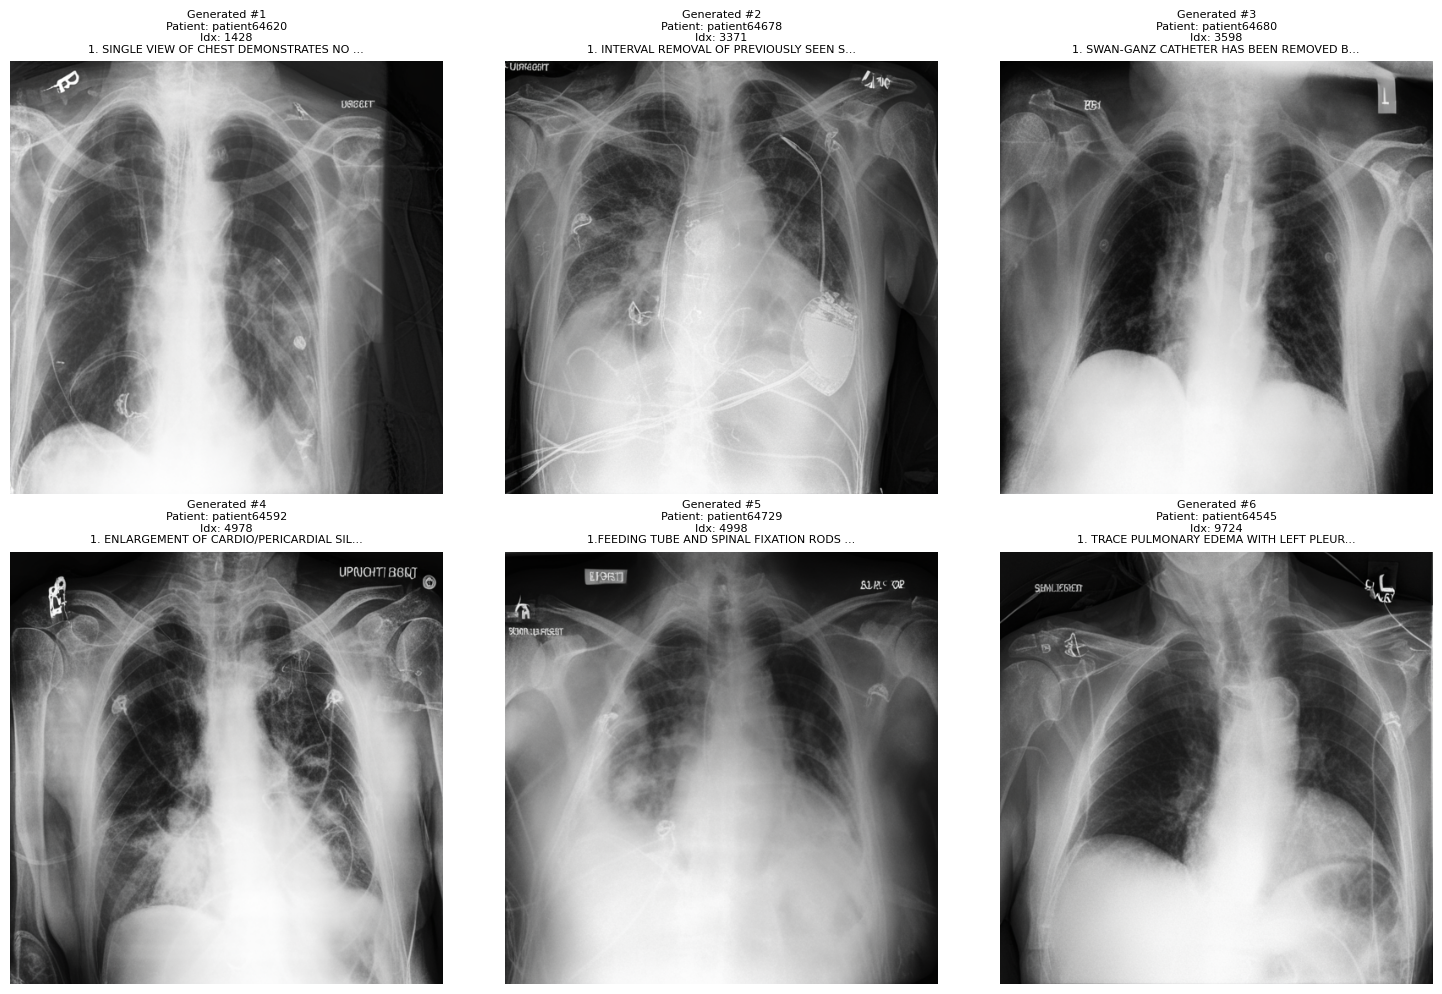

In [8]:
# Display generated images with metadata
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(NUM_SAMPLES):
    ax = axes[i]
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')
    
    # Add metadata as title
    title = f"Generated #{i+1}\n"
    title += f"Patient: {metadata_list[i]['patient_id']}\n"
    title += f"Idx: {metadata_list[i]['original_idx']}\n"
    title += f"{metadata_list[i]['text_prompt'][:40]}..."
    ax.set_title(title, fontsize=8)

plt.tight_layout()
output_path = os.path.join(OUTPUT_DIR, 'generation_from_noise.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"Saved: {output_path}")
plt.show()


### Section B: Ground Truth Comparison


Saved: /home/luab/graph/adhoc_scripts/outputs/groundtruth_vs_generated.png


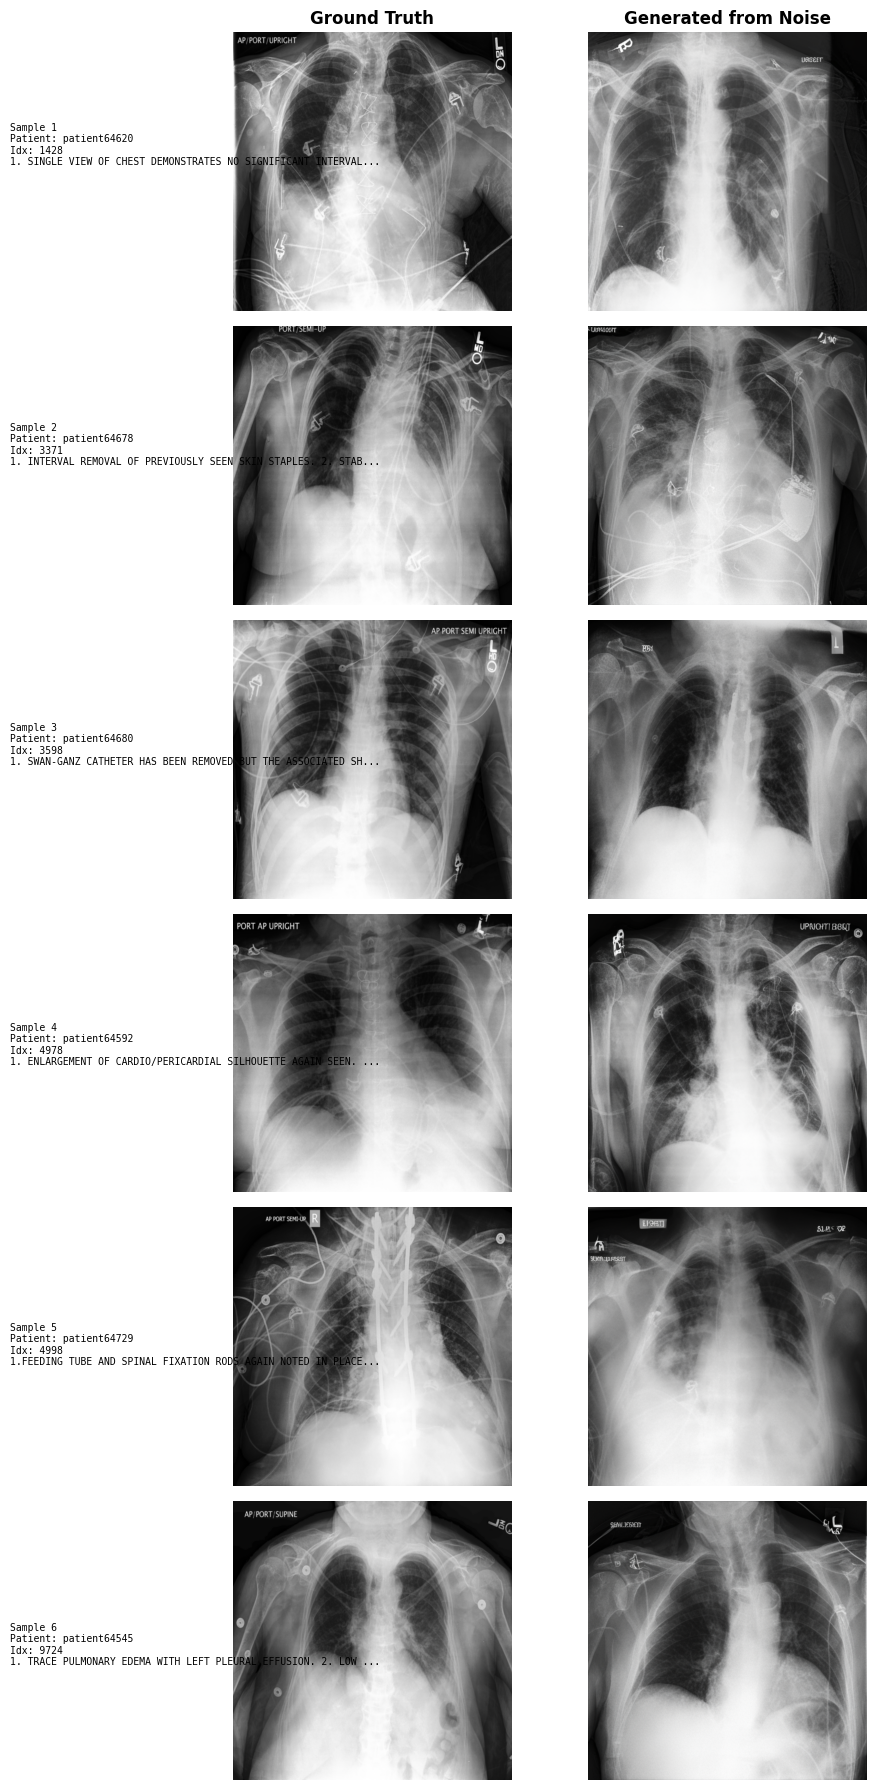

In [9]:
# Display Ground Truth vs Generated side-by-side
fig, axes = plt.subplots(NUM_SAMPLES, 2, figsize=(10, 3*NUM_SAMPLES))

for i in range(NUM_SAMPLES):
    # Ground truth
    ax_gt = axes[i, 0]
    gt_image = tensor_to_pil(metadata_list[i]['ground_truth'])
    ax_gt.imshow(gt_image, cmap='gray')
    ax_gt.axis('off')
    if i == 0:
        ax_gt.set_title('Ground Truth', fontsize=12, fontweight='bold')
    
    # Generated
    ax_gen = axes[i, 1]
    ax_gen.imshow(generated_images[i], cmap='gray')
    ax_gen.axis('off')
    if i == 0:
        ax_gen.set_title('Generated from Noise', fontsize=12, fontweight='bold')
    
    # Add metadata on left
    info_text = f"Sample {i+1}\n"
    info_text += f"Patient: {metadata_list[i]['patient_id']}\n"
    info_text += f"Idx: {metadata_list[i]['original_idx']}\n"
    info_text += f"{metadata_list[i]['text_prompt'][:60]}..."
    fig.text(0.02, 1 - (i + 0.5) / NUM_SAMPLES, info_text, 
             fontsize=7, verticalalignment='center', family='monospace')

plt.tight_layout(rect=[0.12, 0, 1, 1])  # Leave space for text
output_path = os.path.join(OUTPUT_DIR, 'groundtruth_vs_generated.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"Saved: {output_path}")
plt.show()


### Section C: Multi-Seed Comparison


Generating 9 variations from same graph embedding:
  Patient: patient64620
  Prompt: 1. SINGLE VIEW OF CHEST DEMONSTRATES NO SIGNIFICANT INTERVAL CHANGE IN POSITION OF BILATERAL CHEST T...



Generating variations: 100%|██████████| 9/9 [00:43<00:00,  4.78s/it]



Saved: /home/luab/graph/adhoc_scripts/outputs/multi_seed_comparison.png


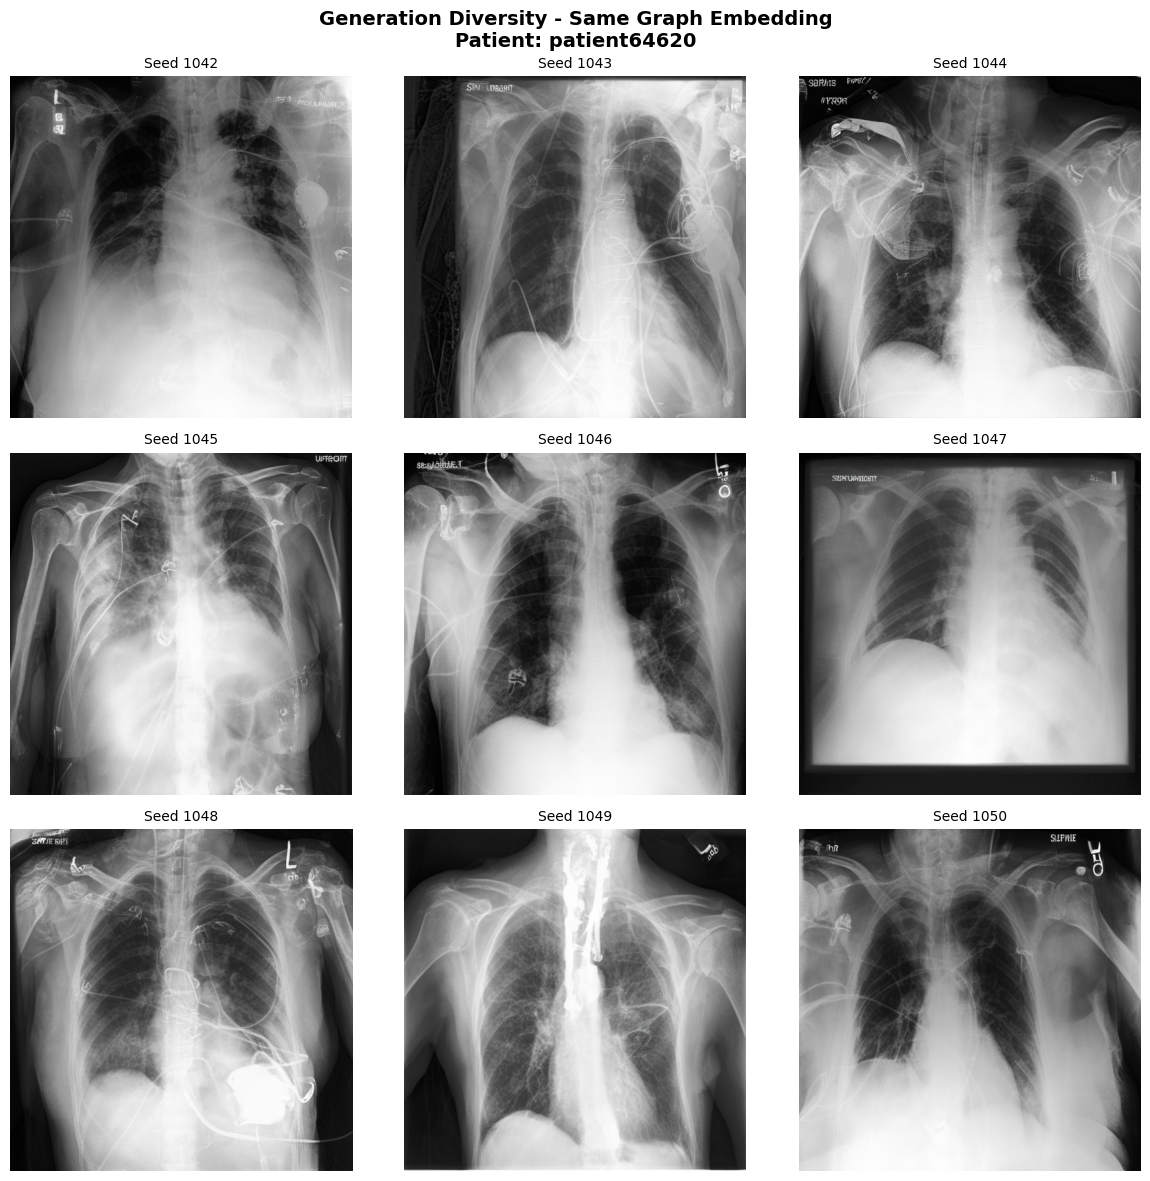

In [10]:
# Select one graph embedding and generate multiple times with different seeds
sample_idx = 0
sample = val_dataset[sample_idx]
graph_embedding = sample['graph_embedding']

print(f"Generating 9 variations from same graph embedding:")
print(f"  Patient: {sample['patient_id']}")
print(f"  Prompt: {sample['text_prompt'][:100]}...\n")

num_variations = 9
variations = []

for i in tqdm(range(num_variations), desc="Generating variations"):
    img = generate_from_noise(graph_embedding, seed=SEED + 1000 + i, show_progress=False)
    variations.append(img)

# Display in 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i in range(num_variations):
    ax = axes[i]
    ax.imshow(variations[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f"Seed {SEED + 1000 + i}", fontsize=10)

fig.suptitle(f"Generation Diversity - Same Graph Embedding\nPatient: {sample['patient_id']}", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
output_path = os.path.join(OUTPUT_DIR, 'multi_seed_comparison.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"\nSaved: {output_path}")
plt.show()


## 8. Summary Statistics


In [11]:
print("="*80)
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nGeneration Performance:")
print(f"  Average time per image: {np.mean(generation_times):.2f}s")
print(f"  Min time: {np.min(generation_times):.2f}s")
print(f"  Max time: {np.max(generation_times):.2f}s")
print(f"  Total samples generated: {NUM_SAMPLES + num_variations}")

if torch.cuda.is_available():
    print(f"\nGPU Memory:")
    print(f"  Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"  Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
    print(f"  Max allocated: {torch.cuda.max_memory_allocated() / 1024**3:.2f} GB")

print(f"\nConfiguration:")
print(f"  Inference steps: {NUM_INFERENCE_STEPS}")
print(f"  Conditioning scale: {CONDITIONING_SCALE}")
print(f"  Guidance scale: {GUIDANCE_SCALE}")
print(f"  Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")

print(f"\nOutputs saved to: {OUTPUT_DIR}")
print(f"  - generation_from_noise.png")
print(f"  - groundtruth_vs_generated.png")
print(f"  - multi_seed_comparison.png")

print("\n" + "="*80)
print("✓ Inspection complete!")
print("="*80)


SUMMARY STATISTICS

Generation Performance:
  Average time per image: 5.54s
  Min time: 4.68s
  Max time: 9.48s
  Total samples generated: 15

GPU Memory:
  Allocated: 3.40 GB
  Reserved: 5.22 GB
  Max allocated: 4.35 GB

Configuration:
  Inference steps: 50
  Conditioning scale: 1.0
  Guidance scale: 1.0
  Image size: 512x512

Outputs saved to: /home/luab/graph/adhoc_scripts/outputs
  - generation_from_noise.png
  - groundtruth_vs_generated.png
  - multi_seed_comparison.png

✓ Inspection complete!
